## Tournament Analysis

Chris Hua // chua@wharton.upenn.edu

In [10]:
import random

from itertools import zip_longest

import networkx as nx

import numpy as np

import pandas as pd

import seaborn as sns

from pandas_ply import install_ply, X, sym_call

install_ply(pd)

%matplotlib inline

%config InlineBackend.figure_format='retina'


We present some functions to do the tournament analysis. 

In [11]:
def print_edges(g):
    """Function to print edges.
    
    For debug purposes.
    Keyword arguments:
    g -- a graph
    """
    for (u, v, d) in g.edges(data=True):
        print(u, v, d)


def grouper(iterable, n, fillvalue=None):
    """Collect data into fixed-length chunks or blocks
    Taken from itertools recipes: https://docs.python.org/2/library/itertools.html#recipes
    grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    """
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)


def rand_pairing(teams, s=None):
    """Generates random pairing of teams
    
    Used for first round of pairing. Subsequent rounds are paired via MW-PM.
    """
    random.seed(s)
    shuffled = random.sample(teams, len(teams))
    return grouper(shuffled, 2)


def win_prob(a, b, strengths):
    """Win probability for a team, per BTL model

    Keyword arguments:
    a -- number of Team A (returns prob A wins)
    b -- number of Team B
    stregnths - vector
    """
    return(strengths[a] / (strengths[a] + strengths[b]))


def win(a, b, strengths):
    """Whether team A wins a round, given opponent's strength
    
    True if A wins vs B, given their probability of winning.
    Uses a random roll to decide.
    Keyword arguments:
    a -- number of Team A 
    b -- number of Team B
    strengths - vector of team strengths  
    """
    roll = np.random.uniform()
    return roll < win_prob(a, b, strengths)


def add_match(a, b, wins, g, strengths):
    """Adds a match and its result to our data structures
    
    Adds the match to the graph, rolls to find winner, increments win counter.
    Keyword arguments:
    a -- number of Team A 
    b -- number of Team B
    strengths - vector of team strengths 
    """
    g.add_edge(a, b, weight=0)
    if(win(a, b, strengths)):
        wins[a] += 1
    else:
        wins[b] += 1


def next_pairing(n_teams, g):
    """Finds maximum weight perfect matching for given state
    
    Returns list of teams and their assignment
    """
    pairs = list(zip(range(n_teams), nx.max_weight_matching(g).values()))
    return(pairs)

def cost_function(x, y, alpha = 2500, beta = 35):
    """'Cost' or weight mechanism for edges
    
    If a possible pairing has a difference of more than 1 win, then we weight it very low
    Otherwise, we return $\alpha - (\beta * \abs(x - y))^2$.
    Keyword arguments:
    x - wins for team A
    y - wins for team B
    alpha - scale parameter
    beta - dispersion parameter
    """
    diff = x - y
    if(diff > 1):
        return 1 
    z = alpha - (beta * abs(diff))**2
    return z


def rebalance(g, wins, beta=10, alpha=250):
    for (u, v, d) in g.edges(data=True):
        if(g.edge[u][v]['weight'] > 0):
            g.edge[u][v]['weight'] = cost_function(wins[u], wins[v], alpha, beta)


def run_round(n_teams, g, wins, strengths):
    for a, b in next_pairing(n_teams, g):
        if(a > b):
            add_match(a, b, wins, g, strengths)

    rebalance(g, wins)


These functions above are used to simulate the tournament functions. Below we present a function to run a tournament for one iteration.

In [12]:
def run_tournament(n_teams=48, n_rounds=6, seed):
    """Runs the complete tournament.
    
    Keyword arguments
    n_teams -- number of teams in tournament
    n_rounds -- number of rounds in tournament
    seed -- seed to use in generating strengths *only*.
    """
    # initiate complete graph
    g = nx.complete_graph(n_teams)

    # initiate teams, strengths, wins
    teams = list(range(n_teams))
    np.random.seed(seed) # reproducible strength
    strengths = np.random.lognormal(size=n_teams)
    #strengths = np.random.exponential(size=n_teams)
    wins = [0] * n_teams

    # initiate edges
    for (u, v, d) in g.edges(data=True):
        g.add_edge(u, v, weight=1)

    # add wins for first round
    np.random.seed(None)
    for a, b in rand_pairing(teams, seed):
        add_match(a, b, wins, g, strengths)

    for i in range(n_rounds - 1):
        #df = pd.DataFrame(list(zip(strengths, wins)), columns=['strength', 'wins'])
        #sns.lmplot(x = "strength", y = "wins", 
         #      data = run_tournament(n_teams, n_rounds, seed), palette="muted")
        run_round(n_teams, g, wins, strengths)

    df = pd.DataFrame(list(zip(strengths, wins)), columns=['strength', 'wins'])
    return(df)


We further define some helper functions. In particular, `simulate_tournament` runs tournaments for a given number of iterations. With a seed set, these will run tournaments with *the same teams* - i.e. the only thing that changes is who wins each round, by the different random number draws.

In [13]:
def simulate_tournament(n_teams, n_rounds, seed, n_simul = 100):
    df = pd.DataFrame()
    for i in range(n_simul):
        df = df.append(pd.DataFrame(data = run_tournament(n_teams, n_rounds, seed)))
    return df
    
def plot_results(n_teams=48, n_rounds=6, seed=None):
    lm = sns.lmplot(x = "strength", y = "wins", 
               data = run_tournament(n_teams, n_rounds, seed), palette="muted")
    axes = lm.axes
    axes[0,0].set_ylim(0,6)
    axes[0,0].set_xlim(0,1)
    

In [ ]:
Here we show the usage of the tournament simulator.

In [14]:
res = simulate_tournament(48, 6, seed = 20, n_simul = 100)

Here we show usage of the output data. We aggregate the data, by each team, and average out the wins per tournament. In particular, we define "break" here as wining 4 or more rounds out of 6 in a tournament. This is a crude mechanism for being noted as "top-k" - typically in 6 round tournaments, getting 4 wins is necessary but not sufficient to advance. 

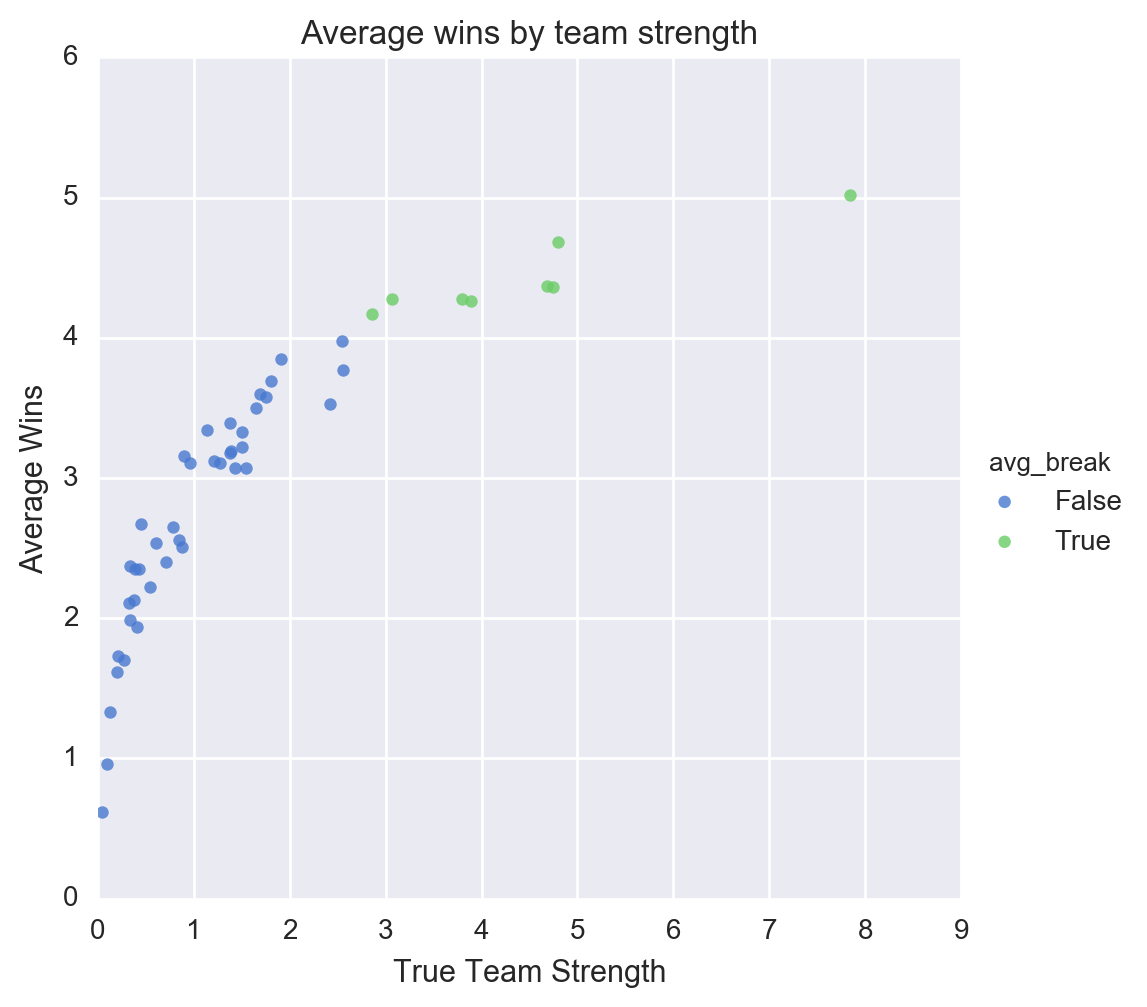

In [22]:
res_summ = (res
    .groupby('strength')
    .ply_select(
        strength = X.strength.mean(),
        avg_wins = X.wins.mean(),
        avg_break = X.wins.mean() > 4
    ))
#res_summ
lm = sns.lmplot(x = "strength", y = "avg_wins",
                hue = "avg_break",
                data = res_summ, palette="muted",
                fit_reg = False)
axes = lm.axes
axes[0,0].set_ylim(0,6)
axes[0,0].set_xlim(0,)
sns.plt.title("Average wins by team strength")
lm.set_xlabels("True Team Strength")
lm.set_ylabels("Average Wins")

In this case, how many teams got 4 wins?

2 - finals
4 - semifinals
8 - quarterfinals
16 - octofinals.

In general, this looks to be pretty close - a medium sized tournament with 48 teams should be breaking to quarterfinals, i.e. taking about 8 teams. This is a bit of a contrived example, since tournaments are usually smaller or larger, but is a useful gut check.

In [24]:
res_summ.groupby('avg_break').count()

,strength,avg_wins
avg_break,,
False,40,40
True,8,8


Finally, we show the actual answer which we are interested in finding. We plot the percent of rounds in which a team got 4 or more wins; that is, a procy for being a top-$k$ team.

The expectations line up with what we would typically expect, as the top eight teams are all each in the top eight above 80% of the time. However, even weak teams can break ~40% of the time, which is relatively surprising.

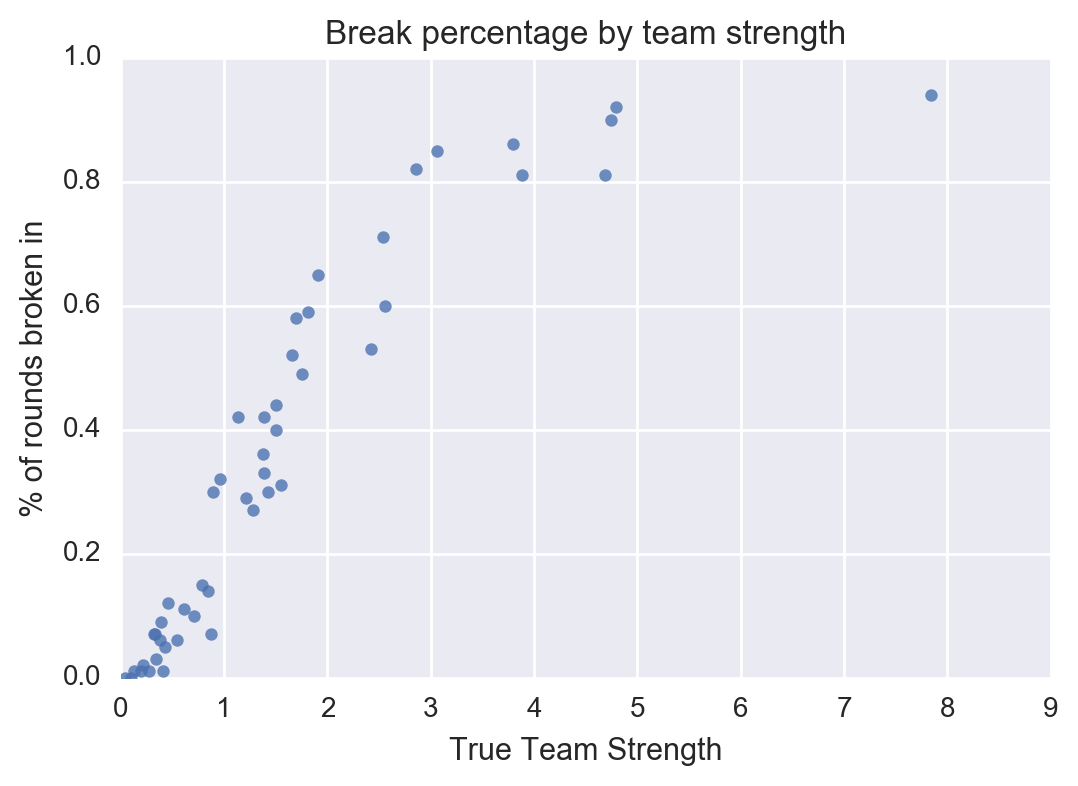

In [16]:
res_breaks = (res
    .groupby('strength')['wins']
    .agg({'n_break': lambda x : (x >= 4).mean()})
)
res_breaks.index.name = 'strength'
res_breaks.reset_index(inplace=True)

lm2 = sns.regplot(x = "strength", y = "n_break",
               data = res_breaks, fit_reg = False)
axes2 = lm2.axes
axes2.set_ylim(0,1)
axes2.set_xlim(0,)
sns.plt.title("Break percentage by team strength")
lm2.set_xlabel("True Team Strength")
lm2.set_ylabel("% of tournaments broken in")

To see what the true effect should be is, we can run tournaments using the same teams but with more rounds. With more rounds, we would expect the true nature of the data to show more.


The break percentages are more limited here. With more rounds, it is harder for a weak team to break.

In [25]:
res2 = simulate_tournament(48, 9, seed = 20, n_simul = 100)

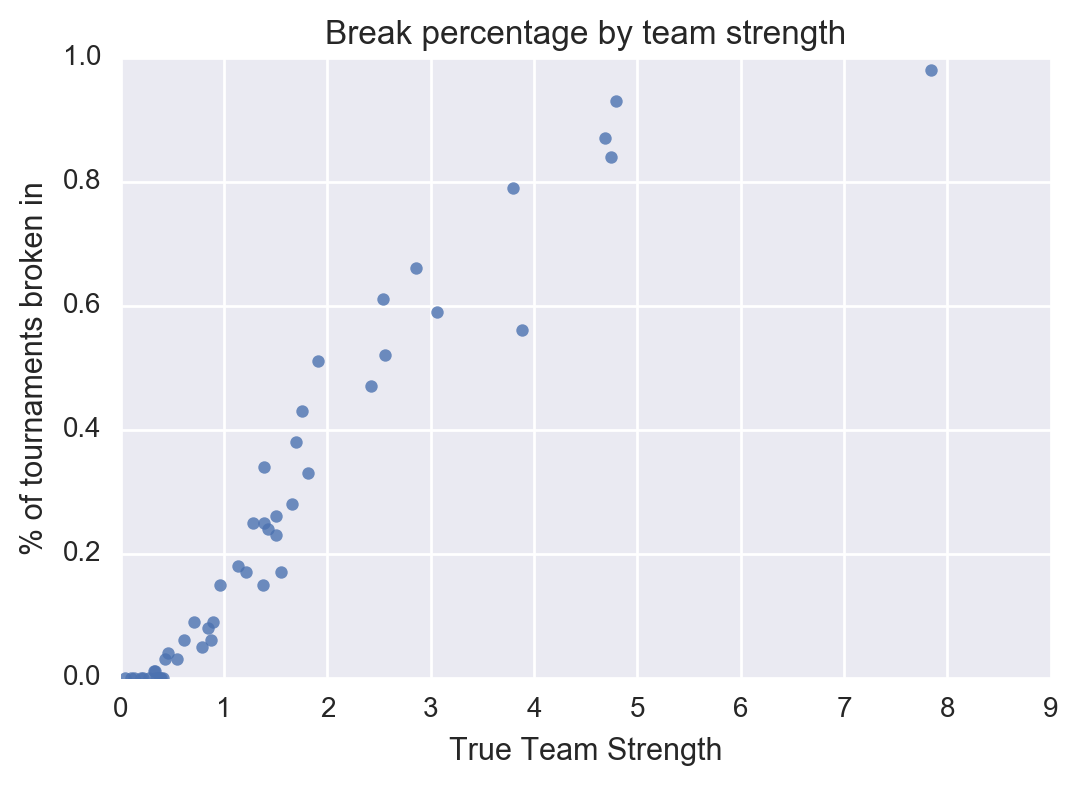

In [27]:
res_breaks2 = (res2
    .groupby('strength')['wins']
    .agg({'n_break': lambda x : (x >= 6).mean()})
)
res_breaks2.index.name = 'strength'
res_breaks2.reset_index(inplace=True)

lm3 = sns.regplot(x = "strength", y = "n_break",
               data = res_breaks2, fit_reg = False)
axes3 = lm3.axes
axes3.set_ylim(0,1)
axes3.set_xlim(0,)
sns.plt.title("Break percentage by team strength")
lm3.set_xlabel("True Team Strength")
lm3.set_ylabel("% of tournaments broken in")